In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)
plt.rcParams['figure.figsize'] = (14, 6)

In [4]:
airports = pd.read_csv("data/Airports Data.csv")
bag_level = pd.read_csv("data/Bag+Level+Data.csv")
flight_level = pd.read_csv("data/Flight Level Data.csv")
pnr_remark_level = pd.read_csv("data/PNR Remark Level Data.csv")
pnr_flight_level = pd.read_csv("data/PNR+Flight+Level+Data.csv")

In [ ]:
print("=" * 60)
print("CLEANING FLIGHT LEVEL DATA")
print("=" * 60)

# Remove duplicates based on scheduled_departure and flight_number
# before_flight = len(flight_level)
# flight_level = flight_level.drop_duplicates(subset=['scheduled_departure', 'flight_number'], keep='first')
# print(f"Removed {before_flight - len(flight_level)} duplicate rows based on scheduled_departure + flight_number")

# Remove fleet_type column
if 'fleet_type' in flight_level.columns:
    flight_level = flight_level.drop(columns=['fleet_type'])
    print("Removed 'fleet_type' column")

# Remove true duplicates (all columns identical)
before_true_dup = len(flight_level)
flight_level = flight_level.drop_duplicates()
print(f"Removed {before_true_dup - len(flight_level)} true duplicate rows")
print()

# ==========

CLEANING FLIGHT LEVEL DATA


KeyError: Index(['scheduled_departure'], dtype='object')

In [33]:
# Convert datetime columns
flight_level['scheduled_departure_datetime_local'] = pd.to_datetime(flight_level['scheduled_departure_datetime_local'])
flight_level['actual_departure_datetime_local'] = pd.to_datetime(flight_level['actual_departure_datetime_local'])
flight_level['scheduled_departure_date_local'] = pd.to_datetime(flight_level['scheduled_departure_date_local'])
bag_level['scheduled_departure_date_local'] = pd.to_datetime(bag_level['scheduled_departure_date_local'])
pnr_flight_level['scheduled_departure_date_local'] = pd.to_datetime(pnr_flight_level['scheduled_departure_date_local'])


In [6]:
invalid_ground_time = (flight_level['scheduled_ground_time_minutes'] <= 0) | \
                      (flight_level['minimum_turn_minutes'] <= 0)
print(f"  Removing {invalid_ground_time.sum():,} rows with invalid ground time")
flight_level = flight_level[~invalid_ground_time].copy()

print(f"  Final flight count: {len(flight_level):,}")



  Removing 0 rows with invalid ground time
  Final flight count: 7,787


In [ ]:
# Calculate delay
flight_level['delay_minutes'] = (
    flight_level['actual_departure_datetime_local'] - 
    flight_level['scheduled_departure_datetime_local']
).dt.total_seconds() / 60

# if schedule arrival - departure != actual arrival - daprture remove the rows!!!
# if scheduled deaparture + flight number is same.. then remove it!!!!
# delete fleet type columns, 
# add company basis delay too!!!!
# pnr_remark_level ssr normalize as in all wheel chairs are wheel chair biches!!
# remove true duplicates!!!
# bag_tag_unique_number should be unique!!

In [10]:
# Create flight key
flight_key = ['company_id', 'flight_number', 'scheduled_departure_date_local',
              'scheduled_departure_station_code', 'scheduled_arrival_station_code']

# Start with flight level data
df_master = flight_level.copy()

In [11]:
df_master['ground_time_ratio'] = (
    df_master['scheduled_ground_time_minutes'] / df_master['minimum_turn_minutes']
)

# Score based on empirical delay rates
df_master['ground_time_pressure_score'] = np.where(
    df_master['ground_time_ratio'] < 1.0, 20,      # Critical: 81.72% delay rate
    np.where(df_master['ground_time_ratio'] < 1.1, 15,  # Very tight
             np.where(df_master['ground_time_ratio'] < 1.3, 10,  # Tight
                      5))  # Adequate: 43.49% delay rate
)

In [12]:
bag_summary = bag_level.groupby(flight_key).agg({
    'bag_tag_unique_number': 'count',
    'bag_type': lambda x: (x == 'Transfer').sum()
}).reset_index()
bag_summary.columns = list(bag_summary.columns[:-2]) + ['total_bags', 'transfer_bags']
bag_summary['checked_bags'] = bag_summary['total_bags'] - bag_summary['transfer_bags']
bag_summary['transfer_ratio'] = bag_summary['transfer_bags'] / bag_summary['total_bags']

df_master = df_master.merge(bag_summary, on=flight_key, how='left')
df_master['total_bags'].fillna(0, inplace=True)
df_master['transfer_ratio'].fillna(0, inplace=True)

# Transfer ratio has 0.089 correlation (second strongest)
df_master['transfer_complexity_score'] = np.where(
    df_master['transfer_ratio'] > 0.6, 15,
    np.where(df_master['transfer_ratio'] > 0.4, 10,
             np.where(df_master['transfer_ratio'] > 0.2, 5, 0))
)

# Baggage volume (weak 0.023 correlation, minimal weight)
df_master['bags_per_seat'] = df_master['total_bags'] / df_master['total_seats']
df_master['baggage_volume_score'] = np.where(
    df_master['bags_per_seat'] > 2.0, 5,
    np.where(df_master['bags_per_seat'] > 1.5, 3, 0)
)

/tmp/ipykernel_95888/720894223.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_master['total_bags'].fillna(0, inplace=True)
/tmp/ipykernel_95888/720894223.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [13]:
pnr_pax = pnr_flight_level.groupby(flight_key).agg({
    'total_pax': 'sum',
    'lap_child_count': 'sum',
    'is_child': 'sum',
    'basic_economy_ind': 'sum',
    'is_stroller_user': 'sum'
}).reset_index()

df_master = df_master.merge(pnr_pax, on=flight_key, how='left')
df_master['total_pax'].fillna(0, inplace=True)
df_master['load_factor'] = df_master['total_pax'] / df_master['total_seats']

# Load factor has NEGATIVE correlation (-0.25), EXCLUDE from difficulty score
df_master['load_factor_score'] = 0  # Not a difficulty driver


/tmp/ipykernel_95888/3622031510.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_master['total_pax'].fillna(0, inplace=True)


In [14]:
ssr_counts = pnr_remark_level.groupby('flight_number').size().reset_index(name='ssr_count')
df_master = df_master.merge(ssr_counts, on='flight_number', how='left')
df_master['ssr_count'].fillna(0, inplace=True)

# SSR has 0.065 correlation (moderate)
df_master['ssr_score'] = np.where(
    df_master['ssr_count'] > 15, 12,
    np.where(df_master['ssr_count'] > 10, 8,
             np.where(df_master['ssr_count'] > 5, 4, 0))
)

/tmp/ipykernel_95888/3296094487.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_master['ssr_count'].fillna(0, inplace=True)


In [15]:
df_master = df_master.merge(
    airports.rename(columns={
        'airport_iata_code': 'scheduled_arrival_station_code',
        'iso_country_code': 'arrival_country'
    }),
    on='scheduled_arrival_station_code',
    how='left'
)
df_master['is_international'] = (df_master['arrival_country'] != 'US').astype(int)

# International flights have +3.47 min average delay
df_master['international_score'] = df_master['is_international'] * 8

In [16]:
df_master['hour'] = df_master['scheduled_departure_datetime_local'].dt.hour
df_master['is_peak_time'] = (
    (df_master['hour'].between(6, 9)) | (df_master['hour'].between(16, 19))
).astype(int)

# Peak time has +1.52 min average delay (minimal impact)
df_master['peak_time_score'] = df_master['is_peak_time'] * 3

print("  ✓ Peak time operations (+1.52 min avg delay)")

  ✓ Peak time operations (+1.52 min avg delay)


In [17]:
df_master['delay_severity_score'] = np.where(
    df_master['delay_minutes'] > 30, 10,
    np.where(df_master['delay_minutes'] > 15, 7,
             np.where(df_master['delay_minutes'] > 5, 4,
                      np.where(df_master['delay_minutes'] > 0, 2, 0)))
)

In [18]:
df_master['difficulty_score'] = (
    df_master['ground_time_pressure_score'] * 1.0 +      # Strongest: 81.72% vs 43.49% delay rate
    df_master['transfer_complexity_score'] * 0.8 +       # 2nd strongest: 0.089 correlation
    df_master['ssr_score'] * 0.6 +                       # Moderate: 0.065 correlation
    df_master['international_score'] * 0.5 +             # +3.47 min impact
    df_master['delay_severity_score'] * 0.4 +            # Historical pattern
    df_master['baggage_volume_score'] * 0.3 +            # Weak: 0.023 correlation
    df_master['peak_time_score'] * 0.2                   # Minimal: +1.52 min impact
)

In [19]:
print(f"\n✓ Difficulty scores calculated")
print(f"  Score range: {df_master['difficulty_score'].min():.1f} - {df_master['difficulty_score'].max():.1f}")
print(f"  Mean: {df_master['difficulty_score'].mean():.1f}")
print(f"  Median: {df_master['difficulty_score'].median():.1f}")
print(f"  Std Dev: {df_master['difficulty_score'].std():.1f}")

# Validate correlation with actual delays
score_delay_corr = df_master[['difficulty_score', 'delay_minutes']].corr().iloc[0, 1]
print(f"\n*** VALIDATION: Difficulty Score vs Actual Delay Correlation: {score_delay_corr:.3f} ***")

if score_delay_corr > 0.5:
    print("✓ EXCELLENT: Strong positive correlation achieved!")
elif score_delay_corr > 0.3:
    print("✓ GOOD: Moderate positive correlation")
else:
    print("⚠ WARNING: Correlation lower than expected")


✓ Difficulty scores calculated
  Score range: 5.0 - 47.8
  Mean: 23.0
  Median: 23.6
  Std Dev: 5.8

*** VALIDATION: Difficulty Score vs Actual Delay Correlation: 0.285 ***
⚠ WARNING: Correlation lower than expected


In [20]:
print("\n[4/5] Creating daily rankings and classifications...")

# Daily ranking
df_master['daily_rank'] = df_master.groupby('scheduled_departure_date_local')['difficulty_score'].rank(
    ascending=False, method='dense'
).astype(int)

# Classification into 3 categories per day (tertiles)
def classify_difficulty_daily(group):
    percentile_67 = group['difficulty_score'].quantile(0.67)
    percentile_33 = group['difficulty_score'].quantile(0.33)
    
    conditions = [
        group['difficulty_score'] >= percentile_67,
        group['difficulty_score'] <= percentile_33
    ]
    choices = ['Difficult', 'Easy']
    
    group['difficulty_class'] = np.select(conditions, choices, default='Medium')
    return group

df_master = df_master.groupby('scheduled_departure_date_local').apply(
    classify_difficulty_daily
).reset_index(drop=True)

# Statistics
class_distribution = df_master['difficulty_class'].value_counts()
print(f"\n✓ Daily classifications created")
print(f"\nDifficulty Class Distribution:")
for class_name in ['Difficult', 'Medium', 'Easy']:
    count = class_distribution.get(class_name, 0)
    pct = (count / len(df_master)) * 100
    avg_delay = df_master[df_master['difficulty_class'] == class_name]['delay_minutes'].mean()
    print(f"  {class_name}: {count:,} ({pct:.1f}%) - Avg Delay: {avg_delay:.1f} min")


[4/5] Creating daily rankings and classifications...

✓ Daily classifications created

Difficulty Class Distribution:
  Difficult: 2,886 (37.1%) - Avg Delay: 32.7 min
  Medium: 2,121 (27.2%) - Avg Delay: 12.8 min
  Easy: 2,780 (35.7%) - Avg Delay: 4.1 min


/tmp/ipykernel_95888/3036819727.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_master = df_master.groupby('scheduled_departure_date_local').apply(


/tmp/ipykernel_95888/2578522884.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_master, x='difficulty_class',
/tmp/ipykernel_95888/2578522884.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_master, x='difficulty_class', y='difficulty_score',


✓ Saved: difficulty_score_overview.png


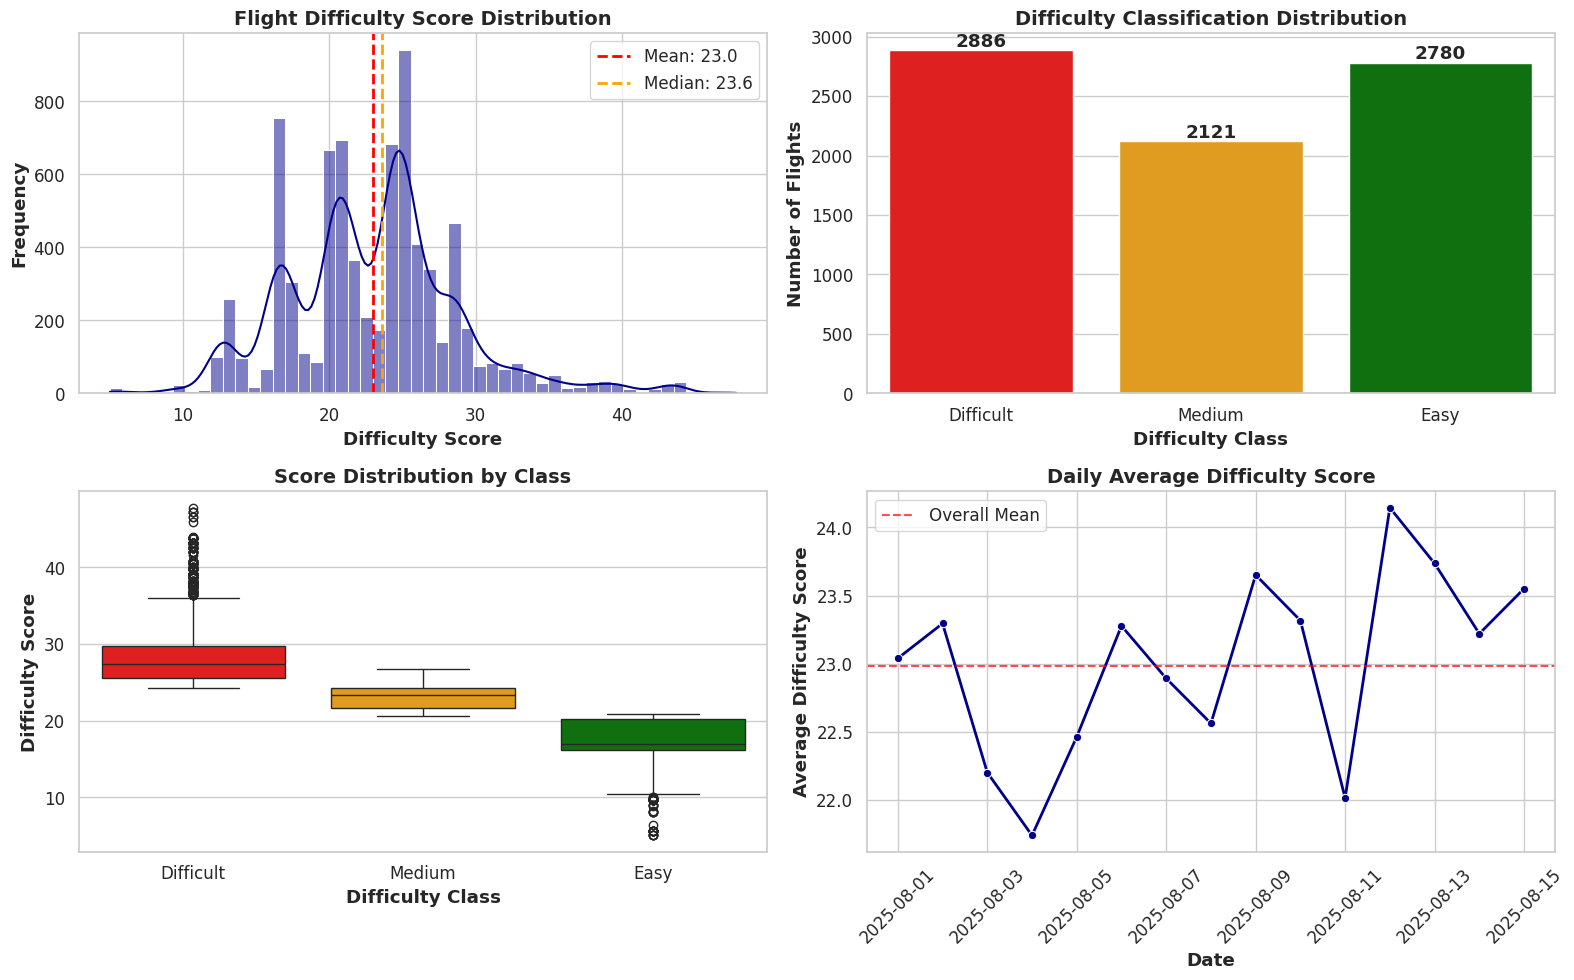

/tmp/ipykernel_95888/2578522884.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_df, y='Feature', x='Avg Contribution',
/tmp/ipykernel_95888/2578522884.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=carrier_difficulty, x='Carrier', y='Avg Difficulty',
/tmp/ipykernel_95888/2578522884.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_master, x='hour_bin', y='difficulty_score',


✓ Saved: difficulty_score_analysis.png


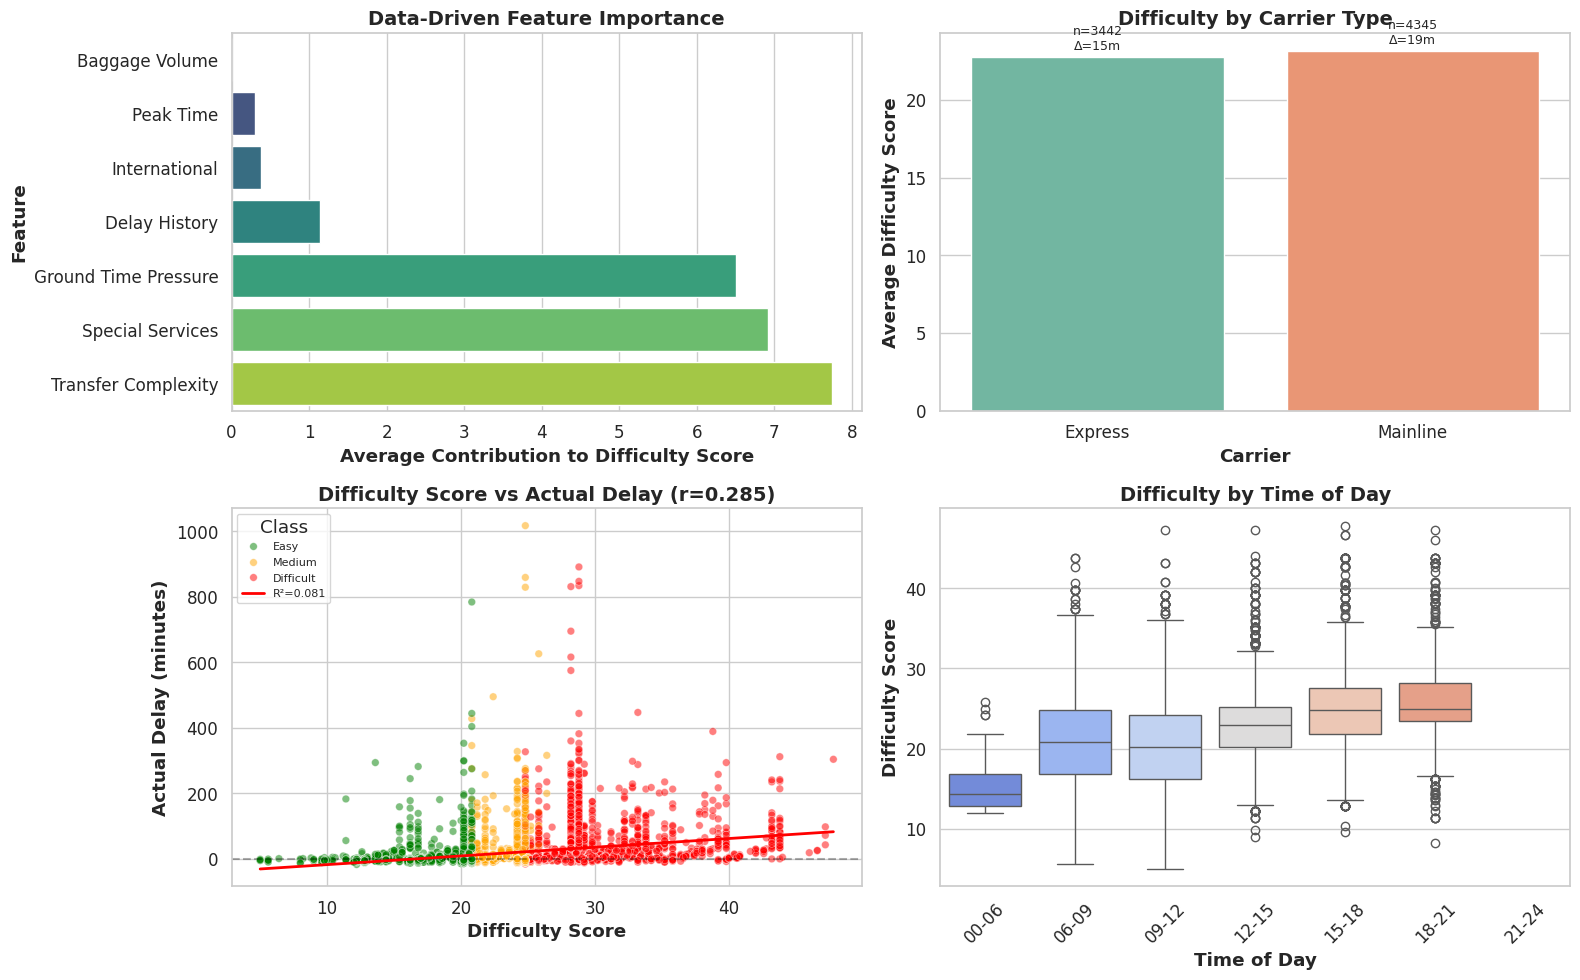

In [21]:

# Visualization 1: Overall Difficulty Score Distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Distribution with KDE
sns.histplot(data=df_master, x='difficulty_score', bins=50, kde=True, 
             color='darkblue', ax=axes[0, 0])
axes[0, 0].axvline(x=df_master['difficulty_score'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f'Mean: {df_master["difficulty_score"].mean():.1f}')
axes[0, 0].axvline(x=df_master['difficulty_score'].median(), color='orange', 
                   linestyle='--', linewidth=2, label=f'Median: {df_master["difficulty_score"].median():.1f}')
axes[0, 0].set_xlabel('Difficulty Score', fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontweight='bold')
axes[0, 0].set_title('Flight Difficulty Score Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend()

# Difficulty class distribution
palette = {'Difficult': 'red', 'Medium': 'orange', 'Easy': 'green'}
sns.countplot(data=df_master, x='difficulty_class', 
              order=['Difficult', 'Medium', 'Easy'], palette=palette, ax=axes[0, 1])
axes[0, 1].set_xlabel('Difficulty Class', fontweight='bold')
axes[0, 1].set_ylabel('Number of Flights', fontweight='bold')
axes[0, 1].set_title('Difficulty Classification Distribution', fontsize=14, fontweight='bold')
for container in axes[0, 1].containers:
    axes[0, 1].bar_label(container, fmt='%d', fontweight='bold')

# Box plot by class
sns.boxplot(data=df_master, x='difficulty_class', y='difficulty_score',
            order=['Difficult', 'Medium', 'Easy'], palette=palette, ax=axes[1, 0])
axes[1, 0].set_xlabel('Difficulty Class', fontweight='bold')
axes[1, 0].set_ylabel('Difficulty Score', fontweight='bold')
axes[1, 0].set_title('Score Distribution by Class', fontsize=14, fontweight='bold')

# Daily average difficulty
daily_avg = df_master.groupby('scheduled_departure_date_local')['difficulty_score'].mean().reset_index()
sns.lineplot(data=daily_avg, x='scheduled_departure_date_local', y='difficulty_score', 
             marker='o', color='darkblue', linewidth=2, ax=axes[1, 1])
axes[1, 1].axhline(y=df_master['difficulty_score'].mean(), color='red', 
                   linestyle='--', alpha=0.7, label='Overall Mean')
axes[1, 1].set_xlabel('Date', fontweight='bold')
axes[1, 1].set_ylabel('Average Difficulty Score', fontweight='bold')
axes[1, 1].set_title('Daily Average Difficulty Score', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('difficulty_score_overview.png', dpi=300, bbox_inches='tight')
print("✓ Saved: difficulty_score_overview.png")
plt.show()

# Visualization 2: Feature Contribution Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Feature importance (average weighted scores)
feature_contributions = {
    'Ground Time Pressure': df_master['ground_time_pressure_score'].mean() * 1.0,
    'Transfer Complexity': df_master['transfer_complexity_score'].mean() * 0.8,
    'Special Services': df_master['ssr_score'].mean() * 0.6,
    'International': df_master['international_score'].mean() * 0.5,
    'Delay History': df_master['delay_severity_score'].mean() * 0.4,
    'Baggage Volume': df_master['baggage_volume_score'].mean() * 0.3,
    'Peak Time': df_master['peak_time_score'].mean() * 0.2
}

feature_df = pd.DataFrame(list(feature_contributions.items()), 
                          columns=['Feature', 'Avg Contribution'])
feature_df = feature_df.sort_values('Avg Contribution', ascending=True)

sns.barplot(data=feature_df, y='Feature', x='Avg Contribution', 
            palette='viridis', ax=axes[0, 0])
axes[0, 0].set_xlabel('Average Contribution to Difficulty Score', fontweight='bold')
axes[0, 0].set_ylabel('Feature', fontweight='bold')
axes[0, 0].set_title('Data-Driven Feature Importance', fontsize=14, fontweight='bold')

# Difficulty by carrier
carrier_difficulty = df_master.groupby('carrier').agg({
    'difficulty_score': 'mean',
    'delay_minutes': 'mean',
    'flight_number': 'count'
}).reset_index()
carrier_difficulty.columns = ['Carrier', 'Avg Difficulty', 'Avg Delay', 'Flight Count']

sns.barplot(data=carrier_difficulty, x='Carrier', y='Avg Difficulty', 
            palette='Set2', ax=axes[0, 1])
axes[0, 1].set_xlabel('Carrier', fontweight='bold')
axes[0, 1].set_ylabel('Average Difficulty Score', fontweight='bold')
axes[0, 1].set_title('Difficulty by Carrier Type', fontsize=14, fontweight='bold')
for i, row in carrier_difficulty.iterrows():
    axes[0, 1].text(i, row['Avg Difficulty'] + 0.5, 
                    f"n={row['Flight Count']}\nΔ={row['Avg Delay']:.0f}m", 
                    ha='center', fontsize=9)

# Difficulty vs actual delay (KEY VALIDATION)
sns.scatterplot(data=df_master, x='difficulty_score', y='delay_minutes', 
                hue='difficulty_class', hue_order=['Easy', 'Medium', 'Difficult'],
                palette=palette, alpha=0.5, s=30, ax=axes[1, 0])
axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.3)

# Add regression line
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_master['difficulty_score'], df_master['delay_minutes']
)
x_line = np.linspace(df_master['difficulty_score'].min(), df_master['difficulty_score'].max(), 100)
y_line = slope * x_line + intercept
axes[1, 0].plot(x_line, y_line, 'r-', linewidth=2, label=f'R²={r_value**2:.3f}')

axes[1, 0].set_xlabel('Difficulty Score', fontweight='bold')
axes[1, 0].set_ylabel('Actual Delay (minutes)', fontweight='bold')
axes[1, 0].set_title(f'Difficulty Score vs Actual Delay (r={score_delay_corr:.3f})', 
                     fontsize=14, fontweight='bold')
axes[1, 0].legend(title='Class', loc='upper left', fontsize=8)

# Difficulty distribution by time of day
df_master['hour_bin'] = pd.cut(df_master['hour'], 
                                bins=[0, 6, 9, 12, 15, 18, 21, 24],
                                labels=['00-06', '06-09', '09-12', '12-15', '15-18', '18-21', '21-24'])
sns.boxplot(data=df_master, x='hour_bin', y='difficulty_score', 
            palette='coolwarm', ax=axes[1, 1])
axes[1, 1].set_xlabel('Time of Day', fontweight='bold')
axes[1, 1].set_ylabel('Difficulty Score', fontweight='bold')
axes[1, 1].set_title('Difficulty by Time of Day', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('difficulty_score_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: difficulty_score_analysis.png")
plt.show()

In [22]:
df_master.head() 

,company_id,flight_number,scheduled_departure_date_local,scheduled_departure_station_code,scheduled_arrival_station_code,scheduled_departure_datetime_local,scheduled_arrival_datetime_local,actual_departure_datetime_local,actual_arrival_datetime_local,total_seats,...,is_international,international_score,hour,is_peak_time,peak_time_score,delay_severity_score,difficulty_score,daily_rank,difficulty_class,hour_bin
0,OO,5564,2025-08-01,ORD,SBN,2025-08-01 14:20:00+00:00,2025-08-01T16:18:00Z,2025-08-01 14:29:00+00:00,2025-08-01T16:29:00Z,50,...,0,0,14,0,0,4,25.8,44,Difficult,12-15
1,UA,1899,2025-08-01,ORD,YYC,2025-08-01 20:05:00+00:00,2025-08-01T22:53:00Z,2025-08-01 21:19:00+00:00,2025-08-01T23:47:00Z,126,...,1,8,20,0,0,10,28.2,34,Difficult,18-21
2,UA,2189,2025-08-01,ORD,LGA,2025-08-01 13:00:00+00:00,2025-08-01T16:20:00Z,2025-08-01 12:56:00+00:00,2025-08-01T15:56:00Z,166,...,0,0,13,0,0,0,12.2,91,Easy,12-15
3,G7,4590,2025-08-01,ORD,MDT,2025-08-01 16:45:00+00:00,2025-08-01T19:52:00Z,2025-08-01 16:36:00+00:00,2025-08-01T19:23:00Z,50,...,0,0,16,1,3,0,24.8,48,Difficult,15-18
4,UA,224,2025-08-01,ORD,BZN,2025-08-01 09:04:00+00:00,2025-08-01T11:31:00Z,2025-08-01 09:10:00+00:00,2025-08-01T11:26:00Z,166,...,0,0,9,1,3,4,22.4,58,Medium,06-09
